# 연습문제 2번 풀이 - 타이타닉 생존률 분석

## #01. 데이터 준비

### 패키지 참조

In [1]:
from pandas import read_excel, DataFrame, merge, get_dummies
from matplotlib import pyplot as plt
from statsmodels.stats.anova import anova_lm
from scipy import stats
import numpy as np
from patsy import dmatrix
import seaborn as sb
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from helper import my_logit, scalling

### 그래프 설정

In [2]:
plt.rcParams['font.family'] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.unicode_minus'] = False

### 데이터셋 준비

In [3]:
df = read_excel("https://data.hossam.kr/E05/titanic.xlsx")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### 결측치 정제

객실번호

선실이 부여되지 않은 경우 객실 등급에 따른 차이가 있는지 여부를 확인

In [4]:
df_tmp = df.filter(['Pclass', 'Cabin']).query('Cabin.isnull()')
df_tmp.fillna(0, inplace=True)
df_tmp.groupby('Pclass').count()

,Cabin
Pclass,
1,40
2,168
3,479


> 객실 번호는 생존 여부에 영향이 없을 것으로 판단하고 변수 자체를 제거(열단위제거)

In [5]:
# 객실번호 컬럼 제거
df1 = df.drop('Cabin', axis=1)
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


탑승지

탑승지 데이터가 결측치인 경우는 2건 밖에 되지 않기 때문에 데이터 정제 과정에서 제거(행단위)

In [6]:
# 탑승지 결측치 제거
df2 = df1.query('Embarked.notnull()')
df2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


나이

연령분포에 대한 커널밀도 그래프 확인

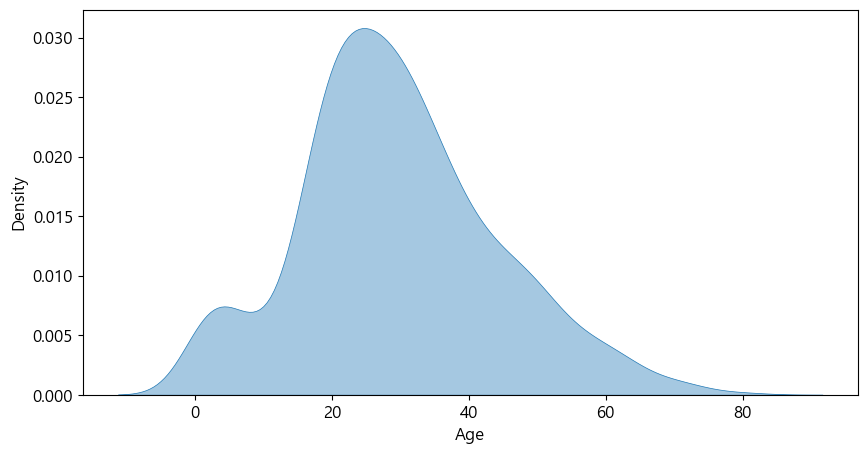

In [7]:
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10,5))
sb.kdeplot(data=df2, x='Age', fill=True, alpha=0.4, linewidth=0.5)
plt.show()
plt.close()

> 20~40 사이의 연령층이 가장 많이 분포되어 있음을 알 수 있다. 60대 이상의 노년층보다는 10세 이하의 어린이가 더 많이 탑승했음을 알 수 있다. 

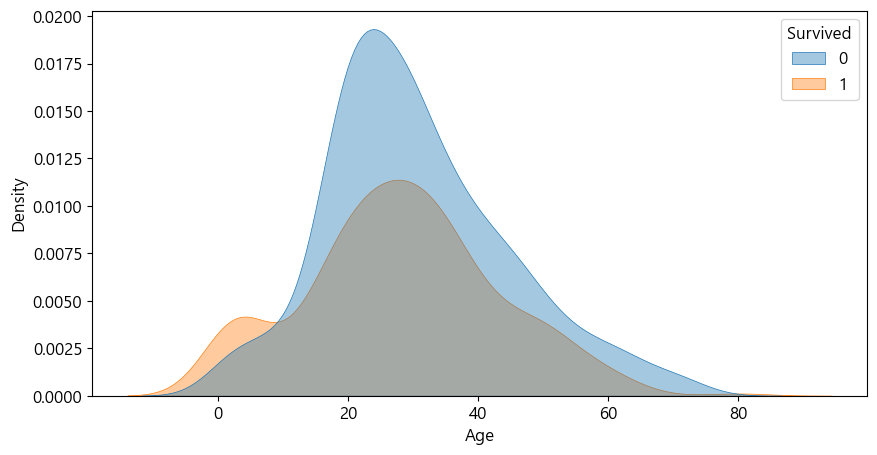

In [8]:
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10,5))
sb.kdeplot(data=df2, x='Age', hue='Survived', fill=True, alpha=0.4, linewidth=0.5)
plt.show()
plt.close()

> 어린이와 청소년층의 경우 사망자 대비 생존자가 더 많이 분포된 것이 확인된다. 20세 이상~30세 정도의 연령층과 60세 이상의 노년층에서는 사망자가 더 많이 분포된 것이 확인된다.

> 위 내용으로 미루어 보아 나이는 생존여부에 영향을 주는 요인으로 판단되어 결측치를 대체하기로 결정

나이를 중앙값으로 대체

나이의 경우 탑승객의 생존여부에 중요한 영향을 미치는 요인이라고 짐작하고 삭제하지 않기로 결정하였다.

연속형 데이터의 결측치를 대체하기에 가장 적합한 값은 중앙값이므로 중앙값으로 대체한다.

In [9]:
# age의 결측치를 중앙값으로 대체
df3 = df2.copy()
df3['Age'].fillna(df3['Age'].median(), inplace=True)
df3.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### 불필요한 필드 제거

탑승객 번호

탑승객 번호는 단순한 일련번호이므로 생존률에 영향을 주지 않는 값이라고 판단하고 이 값을 인덱스로 설정하였다.

In [10]:
# 탑승객번호를 인덱스로 설정
df4 = df3.set_index("PassengerId")
df4.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


이름과 티켓번호

생존여부에 영향을 주지 않는다고 판단하고 제거

In [12]:
# 이름과 티켓번호 컬럼 제거
df5 = df4.drop(['Name', 'Ticket'], axis=1)
df5.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### 더미변수 처리

In [30]:
# pandas의 get_dummies 함수를 사용해서 범주형변수를 처리. 
# 더미변수는 n-1개만 있어도 되기 때문에 처음값은 삭제해도 된다. drop_first = True
cda_df = get_dummies(df5, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True, dtype='int')
cda_df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,1,1,0,1
2,1,38.0,1,0,71.2833,0,0,0,0,0
3,1,26.0,0,0,7.9250,0,1,0,0,1
4,1,35.0,1,0,53.1000,0,0,0,0,1
5,0,35.0,0,0,8.0500,0,1,1,0,1


### 탐색적 데이터 분석을 위한 데이터 타입 변환

dummy 변수 처리 전 상태에서 명목형 변수를 category 타입으로 변환

In [31]:
eda_df = df5.astype({'Survived':'category', 'Pclass': 'category', 'Sex': 'category', 'Embarked': 'category'})
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  889 non-null    category
 1   Pclass    889 non-null    category
 2   Sex       889 non-null    category
 3   Age       889 non-null    float64 
 4   SibSp     889 non-null    int64   
 5   Parch     889 non-null    int64   
 6   Fare      889 non-null    float64 
 7   Embarked  889 non-null    category
dtypes: category(4), float64(2), int64(2)
memory usage: 38.7 KB


In [32]:
eda_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S
889,0,3,female,28.0,1,2,23.4500,S


### 탐색적 데이터 분석

#### 기초 통계량 확인

In [33]:
eda_df.describe()

,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000
mean,29.315152,0.524184,0.382452,32.096681
std,12.984932,1.103705,0.806761,49.697504
min,0.420000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,14.454200
75%,35.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


> 각 요인간의 범위가 크게 다르기 때문에 데이터 표준화가 필요한 것으로 판단된다.

### 생존률 확인하기

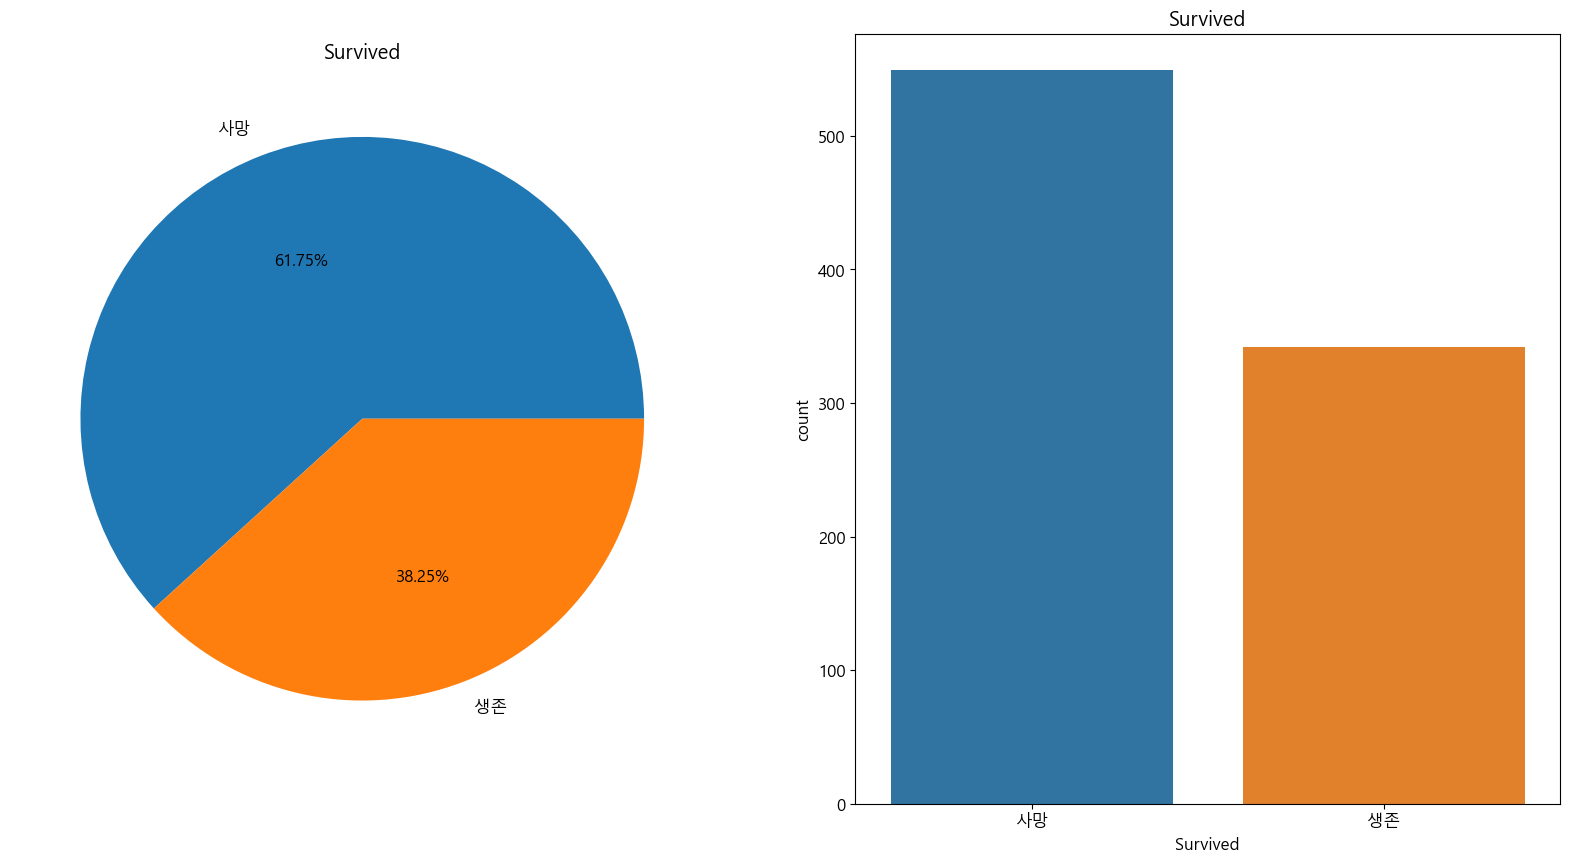

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), dpi = 100)

vc = eda_df['Survived'].value_counts()
ax1.pie(vc, labels=['사망', '생존'], autopct='%1.2f%%')
ax1.set_title('Survived')
ax1.set_ylabel('')

sb.countplot(x=df['Survived'], ax=ax2)
ax2.set_title('Survived')
ax2.set_xticks([0,1])
ax2.set_xticklabels(['사망','생존'])

plt.show()
plt.close()

### 각 선실별 생존자 확인

각 선실별 탑승객 수

In [35]:
pclass_total_df = eda_df.filter(['Pclass', 'Survived']).groupby('Pclass').count()
pclass_total_df

,Survived
Pclass,
1,214
2,184
3,491


각 선실별 생존자 수

In [36]:
pclass_surv_df = eda_df.filter(['Pclass', 'Survived']).query('Survived==1').groupby('Pclass').count()
pclass_surv_df

,Survived
Pclass,
1,134
2,87
3,119


각 선실별 생존자 비율

In [37]:
ratio = (pclass_surv_df['Survived']/pclass_total_df['Survived']) * 100
ratio

Pclass
1    62.616822
2    47.282609
3    24.236253
Name: Survived, dtype: float64

> 탑승객이 가장 많았던 3등급 객실의 생존자 비율은 24.2%밖에 되지 않고, 탑승객 비율이 크게 높지 않은 1등급 객실의 경우 63%의 승객이 생존했다.

각 선실별 생존자 비율 시각화

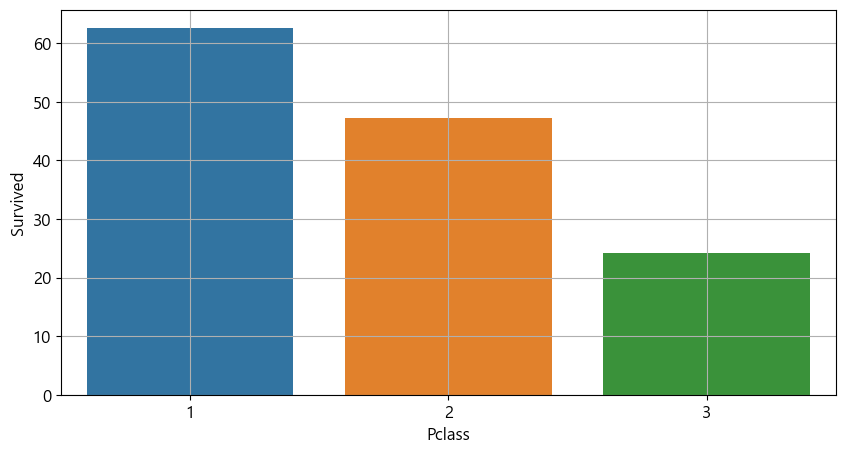

In [38]:
plt.figure()
sb.barplot(x=ratio.index, y=ratio)
plt.grid()
plt.ylabel('Survived')
plt.show()
plt.close()

> 부유층이 많이 탑승했을 것으로 예상되는 1등급 객실의 생존비율이 가장 높은 것을 알 수 있다.

### 성별에 따른 생존률

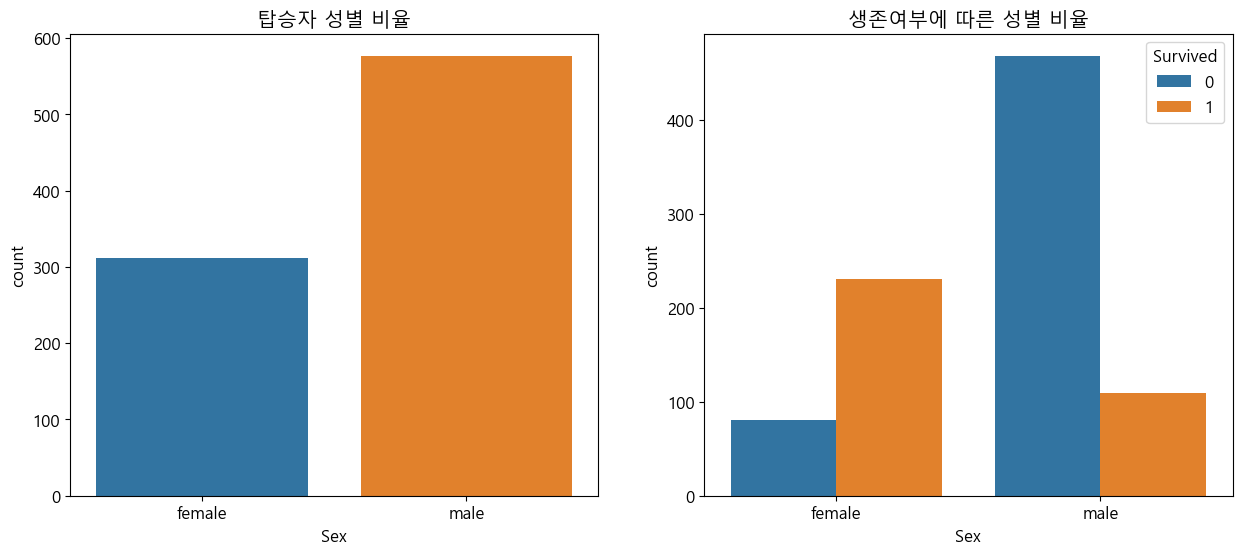

In [39]:
f, ax = plt.subplots(1,2, figsize=(15,6))

sb.countplot(x='Sex', data=eda_df, ax=ax[0])
ax[0].set_title('탑승자 성별 비율')

sb.countplot(x='Sex', hue='Survived', data=eda_df, ax=ax[1])
ax[1].set_title('생존여부에 따른 성별 비율')

plt.show()
plt.close()

> 왼쪽의 그래프를 보면 전체 탑승객의 성비는 남자가 더 높은 것으로 나타난다. 하지만 성별에 따른 생존률 비율은 여자가 더 높은 비율로 생존하였고, 남자의 생존비율은 전체 탑승객 수 대비 현저히 낮은 것으로 파악되었다.

### 로지스틱 회귀

#### 분석수행

In [40]:
x = list(cda_df.columns)
x.remove('Survived')
logit_result = my_logit(cda_df, y='Survived', x=x)
print(logit_result.summary)

Optimization terminated successfully.
         Current function value: 0.441182
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  889
Model:                          Logit   Df Residuals:                      879
Method:                           MLE   Df Model:                            9
Date:                Tue, 01 Aug 2023   Pseudo R-squ.:                  0.3368
Time:                        13:50:09   Log-Likelihood:                -392.21
converged:                       True   LL-Null:                       -591.41
Covariance Type:            nonrobust   LLR p-value:                 3.013e-80
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0625      0.473      8.594      0.000       3.136       4.989
Age           -0.0388      0.

### 혼동행렬

In [41]:
logit_result.cmdf

,Negative,Positive
True,478,238
False,102,71


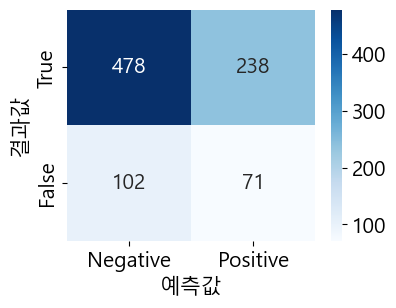

In [42]:
plt.rcParams['figure.figsize'] = (4,3)
plt.rcParams['font.size'] = 15

sb.heatmap(logit_result.cmdf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('예측값')
plt.ylabel('결과값')
plt.show()

### 평가지표

In [43]:
logit_result.result_df

,설명력(Pseudo-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)",f1_score,위양성율,특이성
0,0.336819,0.805399,0.770227,0.7,0.733436,0.129326,0.870674


### 실제 데이터 예측해보기

In [46]:
test_df = DataFrame({
    'dicaprio':[19,0,0,0,0,1,1,1,0],
    'winslet': [17,1,1,100,0,0,0,0,1],
    'me': [27,1,0,0,0,1,0,1,0]
}, index=['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S'])

vdf = test_df.T
vdf

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
dicaprio,19,0,0,0,0,1,1,1,0
winslet,17,1,1,100,0,0,0,0,1
me,27,1,0,0,0,1,0,1,0


In [47]:
result = logit_result.fit.predict(vdf)
result

dicaprio    0.169957
winslet     0.941705
me          0.621017
dtype: float64

In [49]:
for i, v in enumerate(result.index):
    print("%s님의 생존확률은 %.2f%%입니다."% (v, result[i]*100))

dicaprio님의 생존확률은 17.00%입니다.
winslet님의 생존확률은 94.17%입니다.
me님의 생존확률은 62.10%입니다.
